In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics
from get_bounds import *

### Grid Points Load (output from scoring.ipynb)
#### Grid Points are now scored in `scoring.ipynb`.

In [38]:
YYZ_GridPoints = pd.read_csv('../res/grid_points/yyz_grid_points.csv', sep = ',')

### Parameters

In [39]:
STD_DEV = 0.6
PT_DENSITY = 50

### Regression

In [40]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)
    
    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()
    
    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [41]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    #x = scores['lat'].unique()
    x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

### Filtering and Processing

In [42]:
def trimOutOfBounds(points, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    df = pd.DataFrame({'lat': points[0], 'long': points[1]})
    df = df.loc[(df['lat'] >= bottomLatBound) & (df['lat'] <= upperLatBound) & (df['long'] >= leftLongBound) & (df['long'] <= rightLongBound)]
    return (df['lat'].values, df['long'].values)

In [43]:
def snapLongToGrid(points, leftLongBound, rightLongBound):
    step = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)
    pointsDf = pd.DataFrame({'lat': points[0], 'long': points[1]})
    for index, row in pointsDf.iterrows():
        pointsDf.at[index, 'long'] = pointsDf.at[index, 'long'] - ((pointsDf.at[index, 'long'] - leftLongBound) % step)
    return (pointsDf['lat'].values, pointsDf['long'].values)

### Plotting Functions

In [44]:
def plotScores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.scatter(scores["lat"], scores["long"], scores["score"])
    return ax

In [45]:
def plotScoresWithLine(scores, line):
    ax = plotScores(scores)
    ax.plot([line[0], line[1]], [line[2], line[3]], [0, 0], color='red', linewidth=3)
    return ax

In [46]:
def plotScoresWithCurve(scores, curve):
    ax = plotScores(scores)
    ax.scatter(curve[0], curve[1], 0)
    return ax

In [47]:
def plotHeatmap(scores, line):
    y_begin = line[2]
    y_end = line[3]
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    y_begin_hm = int((y_begin - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    y_end_hm = int((y_end - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    ax.plot([0, PT_DENSITY], [y_begin_hm, y_end_hm], linewidth=3, color='r')
    return ax

In [48]:
def plotHeatmapPolynomial(scores, curves):
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    for curve in curves:
        x = curve[0]
        y = curve[1]
        x_hm = [int(a) for a in ((x - scores["lat"].iloc[0]) / (scores["lat"].iloc[-1] - scores["lat"].iloc[0]) * PT_DENSITY)]
        y_hm = [int(a) for a in ((y - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)]
        ax.scatter(x_hm, y_hm, linewidth=1)
    return ax

### Toronto (YYZ)

In [49]:
[YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound] = getBounds(YYZ_GridPoints['lat'], YYZ_GridPoints['long'], 4)

In [50]:
[*YYZ_Line_1, YYZ_Line_1_intercept, YYZ_Line_1_coefficients] = polynomialRegression(YYZ_GridPoints, 3, YYZ_UpperLatBound, YYZ_BottomLatBound)
YYZ_Line_1 = trimOutOfBounds(YYZ_Line_1, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
YYZ_Line_1 = snapLongToGrid(YYZ_Line_1, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

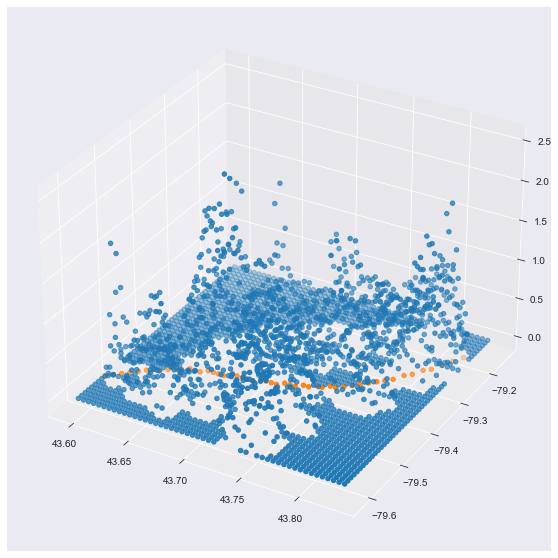

In [51]:
plotScoresWithCurve(YYZ_GridPoints, YYZ_Line_1)

<AxesSubplot:xlabel='lat', ylabel='long'>

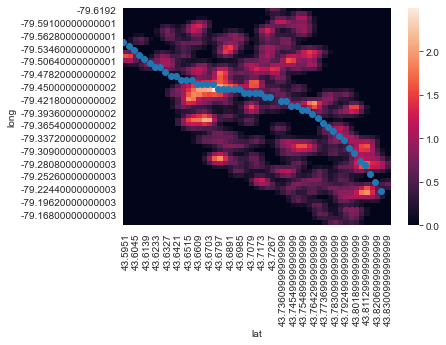

In [52]:
plotHeatmapPolynomial(YYZ_GridPoints, [YYZ_Line_1])

### Clustering Test

In [53]:
NUM_CLUSTERS = 5

In [54]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
YYZ_C_Scores = YYZ_GridPoints.copy()
YYZ_C_Scores = YYZ_C_Scores.loc[YYZ_C_Scores['score'] > 0.5]

In [55]:
#for index, row in YYZ_C_Scores.iterrows():
#    YYZ_C_Scores.at[index, 'score'] = (YYZ_C_Scores.at[index, 'score']*2)**2

In [56]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(YYZ_C_Scores[["lat", "long"]], 0, YYZ_C_Scores["score"])

In [57]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(YYZ_C_Scores[["lat", "long"]])
    distortions.append(kmeanModel.inertia_)

AttributeError: 'NoneType' object has no attribute 'split'

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

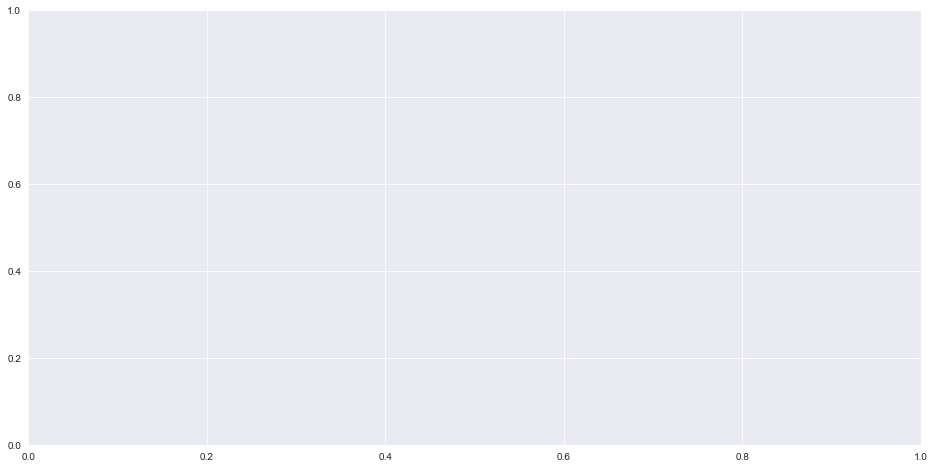

In [58]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

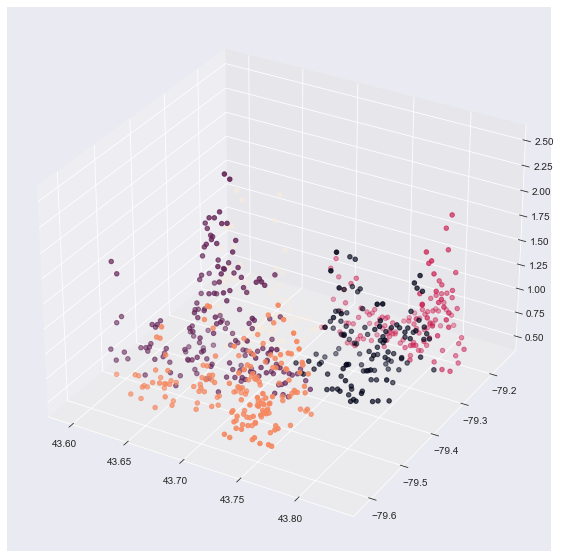

In [59]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], YYZ_C_Scores["score"], c=kmeans.labels_.astype(float))

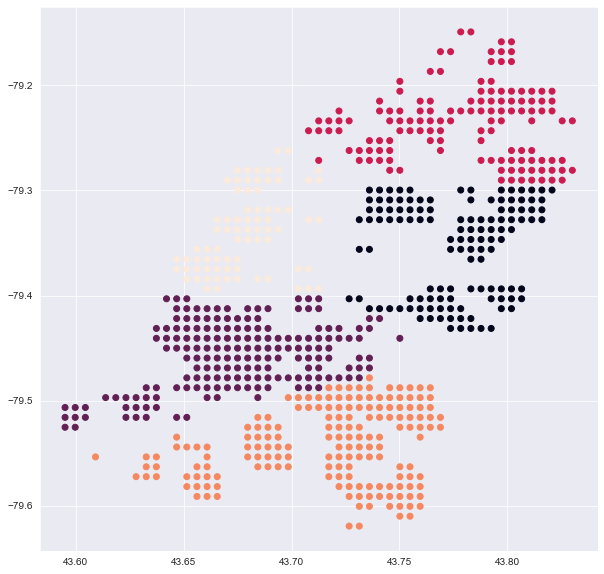

In [60]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], c=kmeans.labels_.astype(float))

In [61]:
YYZ_C_Scores['cluster'] = kmeans.labels_.tolist()

In [62]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, 5, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right)
    return (line, line_intercept, line_coefficients)

In [63]:
YYZ_Cx_Scores = []
for i in range(NUM_CLUSTERS):
    YYZ_Cx_Scores.append(YYZ_C_Scores.loc[YYZ_C_Scores['cluster'] == i])

In [64]:
YYZ_Cx_Line = []
for i in range(NUM_CLUSTERS):
    [line, _, _] = getLine(YYZ_Cx_Scores[i], YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
    YYZ_Cx_Line.append(line)

<AxesSubplot:xlabel='lat', ylabel='long'>

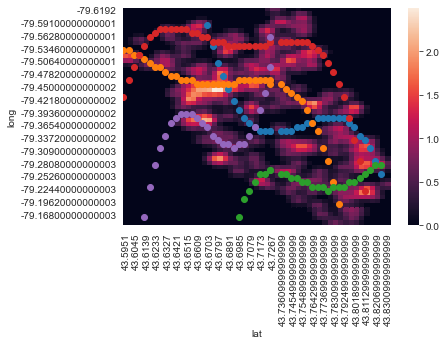

In [65]:
plotHeatmapPolynomial(YYZ_GridPoints, YYZ_Cx_Line)

In [66]:
YYZ_Cx_Line

[(array([43.6703, 43.675 , 43.6797, 43.6844, 43.6891, 43.6938, 43.6985,
         43.7032, 43.7079, 43.7126, 43.7173, 43.722 , 43.7267, 43.7314,
         43.7361, 43.7408, 43.7455, 43.7502, 43.7549, 43.7596, 43.7643,
         43.769 , 43.7737, 43.7784, 43.7831, 43.7878, 43.7925, 43.7972,
         43.8019, 43.8066, 43.8113, 43.816 , 43.8207, 43.8254]),
  array([-79.5816, -79.5346, -79.497 , -79.4688, -79.4406, -79.4124,
         -79.3936, -79.3748, -79.3654, -79.356 , -79.3466, -79.3466,
         -79.3466, -79.3466, -79.3466, -79.3466, -79.3466, -79.356 ,
         -79.356 , -79.3654, -79.3654, -79.3748, -79.3748, -79.3748,
         -79.3748, -79.3748, -79.3748, -79.3654, -79.356 , -79.3372,
         -79.3278, -79.309 , -79.2808, -79.2526])),
 (array([43.5951, 43.5998, 43.6045, 43.6092, 43.6139, 43.6186, 43.6233,
         43.628 , 43.6327, 43.6374, 43.6421, 43.6468, 43.6515, 43.6562,
         43.6609, 43.6656, 43.6703, 43.675 , 43.6797, 43.6844, 43.6891,
         43.6938, 43.6985, 43.7032

### Export Cells

In [67]:
with open('coords.txt', 'w') as f:
    f.write("----------LATS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for lat in line[0]:
            f.write(str(lat))
            f.write(',')
        f.write("],")
        f.write("\n")
    f.write("----------LONGS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for long in line[1]:
            f.write(str(long))
            f.write(',')
        f.write("],")
        f.write("\n")

### Toronto Test (Preliminary Work for Interchanges)

# Finding Stations

In [62]:
def getDistance(origin, stationCor):
    return abs(geodesic(origin, stationCor).meters/1000)

In [63]:
#line numbers are 0 indexed
#distance in km
YYZ_Cx_Station = []

def stationFinder(statDistance, subwayLines, lineNum, YYZ_Cx_Station):

    size = len(subwayLines[lineNum][0])

    lati = subwayLines[lineNum][0][0]
    longi = subwayLines[lineNum][1][0]

    stationCor = (lati, longi)
    placeStation = stationCor

    d = {'lat': [lati], 'long': [longi]}
    df = pd.DataFrame(data=d)

    for index in range(0, size - 1):

        lati2 = subwayLines[lineNum][0][index + 1]
        longi2 = subwayLines[lineNum][1][index + 1]

        nextStation = (lati2, longi2)

        distance = getDistance(nextStation, placeStation)

        if distance >= statDistance:

            new_row = {'lat': lati2, 'long': longi2}
            df = df.append(new_row, ignore_index=True)

            placeStation = nextStation


    #convert data frame to numpy array to append to list so we can plot
    lineStat = (df['lat'].values, df['long'].values)

    YYZ_Cx_Station.append(lineStat)

    #return the new set of points
    return YYZ_Cx_Station

In [64]:
#lineNum is not 0 indexed
def getStation(statDistance, lineNum):
    for idx in range(0, lineNum):
        stationFinder(statDistance,YYZ_Cx_Line, idx, YYZ_Cx_Station)
    return YYZ_Cx_Station

In [65]:
getStation(2, 5)

[(array([43.6703, 43.675 , 43.6797, 43.6844, 43.6891, 43.6938, 43.7032,
         43.7173, 43.7361, 43.7549, 43.769 , 43.7878, 43.8019, 43.8113,
         43.8207, 43.8254]),
  array([-79.5816, -79.5346, -79.497 , -79.4688, -79.4406, -79.4124,
         -79.3748, -79.3466, -79.3466, -79.356 , -79.3748, -79.3748,
         -79.356 , -79.3278, -79.2808, -79.2526])),
 (array([43.5951, 43.6139, 43.628 , 43.6421, 43.6609, 43.6797, 43.6985,
         43.7173, 43.7361, 43.7502, 43.7596, 43.7643, 43.7737, 43.7784,
         43.7831, 43.7878]),
  array([-79.5252, -79.5064, -79.4876, -79.4688, -79.45  , -79.45  ,
         -79.4594, -79.4594, -79.45  , -79.4218, -79.3936, -79.3654,
         -79.309 , -79.2808, -79.2338, -79.1868])),
 (array([43.6985, 43.7032, 43.7126, 43.7267, 43.7455, 43.7643, 43.7831,
         43.8019, 43.816 ]),
  array([-79.1586, -79.1962, -79.2338, -79.262 , -79.2432, -79.2244,
         -79.2244, -79.2338, -79.262 ])),
 (array([43.5951, 43.5998, 43.6045, 43.6092, 43.6186, 43.6327,

<AxesSubplot:xlabel='lat', ylabel='long'>

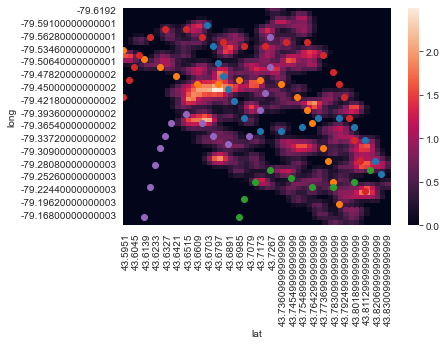

In [66]:
plotHeatmapPolynomial(YYZ_GridPoints, YYZ_Cx_Station)